In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu May 21 05:18:21 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.utils.data as loader
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary

In [0]:
from torch.utils.data import Dataset
import gzip
import os
class ModelNet10GAN(Dataset):
    """
    Custom dataset for training a 3D-GAN, without using a variational autoencoder.
    I have not implemented download of dataset. Also keep a minimum RAM of 12 GB.
    """
    def __init__(self, dir="./", download=False):
        """
        Args:
            dir (string): Path in which you want the dataset 
                to be saved (keep a minimum space of 9 GBs).
            download (boolean): Set to True if you want to download. 
                Default=False.
        """
        self.dir=dir
        self.download=download
        if not self._check_exists():
            raise RuntimeError('chair.npy.gz not present in '+self.dir)
        with gzip.open(self.dir+'chair.npy.gz','rb') as f:
            self.arr=np.load(f)
        
        
 
    def __getitem__(self, ind):
        """
        Args:
            ind (int): Index of the sample you want. 
 
        Returns:
            Tensor: (torch.Tensor, Size: (1,64,64,64))
        """
        return torch.tensor(self.arr[ind+1]).float()
 
    def __len__(self):
        return (self.arr.shape[0]-1)
 
    def _check_exists(self):
        return (os.path.exists(self.dir+"chair.npy.gz"))

In [0]:
# Storing device
device = "cuda:0" if torch.cuda.is_available() else "cpu"
# Defining ModelNet10 dataset for GAN
dataset=ModelNet10GAN(dir='./')
# Defining batch-size for every iteration.
batchsize=50
# Loading dataset into dataloader
data_loader=loader.DataLoader(dataset, batch_size=batchsize)

In [0]:
# This is the input vector size. Default = 200 (as per paper)
vectorSize=200

In [0]:
class generator(nn.Module):
    """
    Generator for 3D-GAN-
    The generator consists of five fully convolution layers with numbers of channels
    {512, 256, 128, 64, 1}, kernel sizes {4, 4, 4, 4, 4}, and strides {1, 2, 2, 2, 2}. 
    We add ReLU and batch normalization layers between convolutional layers, and a Sigmoid
    layer at the end. The input is a 200-dimensional vector, and the output is a 64 × 64 × 64 
    matrix with values in [0, 1].
    """
    def __init__(self):
        super().__init__()
        self.layer1=nn.Sequential(
            nn.ConvTranspose3d(in_channels=200,out_channels=512,kernel_size=2,stride=1,bias=False),
            nn.BatchNorm3d(512),
            nn.ReLU(True),
        )
        self.layer2=nn.Sequential(
            nn.ConvTranspose3d(in_channels=512,out_channels=256,kernel_size=2,stride=2,bias=False),
            nn.BatchNorm3d(256),
            nn.ReLU(True),
        )
        self.layer3=nn.Sequential(
            nn.ConvTranspose3d(in_channels=256,out_channels=128,kernel_size=2,stride=2,bias=False),
            nn.BatchNorm3d(128),
            nn.ReLU(True),
        )
        self.layer4=nn.Sequential(
            nn.ConvTranspose3d(in_channels=128,out_channels=64,kernel_size=2,stride=2,bias=False),
            nn.BatchNorm3d(64),
            nn.ReLU(True),
        )
        self.layer5=nn.Sequential(
            nn.ConvTranspose3d(in_channels=64,out_channels=1,kernel_size=2,stride=2,bias=False),
            nn.Sigmoid(),
        )
    
    def forward(self,x):
        bsize=x.size(0)
        x=x.view(bsize,vectorSize,1,1,1)
        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        x=self.layer4(x)
        x=self.layer5(x)
        return x
G_=generator().to(device)
class discriminator(nn.Module):
    """
    Discriminator for 3D-GAN-
    As a mirrored version of the generator, the discriminator takes as input a 
    64 × 64 × 64 matrix, and outputs a real number in [0, 1]. The discriminator 
    consists of 5 volumetric convolution layers, with numbers of channels {64,128,256,512,1}, 
    kernel sizes {4,4,4,4,4}, and strides {2, 2, 2, 2, 1}. There are leaky ReLU layers of 
    parameter 0.2 and batch normalization layers in between, and a Sigmoid layer at the end.
    """
    def __init__(self):
        super().__init__()
        self.layer1=nn.Sequential(
            nn.Conv3d(in_channels=1,out_channels=64,kernel_size=3,stride=2,bias=False),
            nn.BatchNorm3d(64),
            nn.LeakyReLU(0.2,inplace=True)
        )
        self.layer2=nn.Sequential(
            nn.Conv3d(in_channels=64,out_channels=128,kernel_size=3,stride=2,bias=False),
            nn.BatchNorm3d(128),
            nn.LeakyReLU(0.2,inplace=True)
        )
        self.layer3=nn.Sequential(
            nn.Conv3d(in_channels=128,out_channels=256,kernel_size=3,stride=2,bias=False),
            nn.BatchNorm3d(256),
            nn.LeakyReLU(0.2,inplace=True)
        )
        self.layer4=nn.Sequential(
            nn.Conv3d(in_channels=256,out_channels=512,kernel_size=3,stride=2,bias=False),
            nn.BatchNorm3d(512),
            nn.LeakyReLU(0.2,inplace=True)
        )
        self.layer5=nn.Sequential(
            nn.Conv3d(in_channels=512,out_channels=1,kernel_size=1,stride=1,bias=False),
            nn.Sigmoid()
        )
 
    def forward(self,x):
        bsize=x.size(0)
        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        x=self.layer4(x)
        x=self.layer5(x)
        x=x.view(bsize,1)
        return x
D_=discriminator().to(device)

In [0]:
# Number of epochs you want it to train for.
num_epochs=500 
# Actually 50000, but don't have the resources.

# If you want to continue training from prev. saved model, uncomment the lines below.
# G_.load_state_dict(torch.load('./'))
# D_.load_state_dict(torch.load('./'))

# Defining the optimizers, Adam, with lr as specified in the paper.
optimizerD=optim.Adam(D_.parameters(),lr=0.00005,betas=(0.5,0.999))
optimizerG=optim.Adam(G_.parameters(),lr=0.0025,betas=(0.5,0.999))

# Not defining loss here. Defined manually in training section.

In [32]:
# Arrays to store d_losses and g_losses.
G_losses=[]
D_losses=[]
iters = 0
print("Starting training loop...")

for epoch in range(num_epochs):

    # For each batch in epoch.
    
    RunningLossG=0
    RunningLossD=0

    for i,data in enumerate(data_loader,1):
        optimizerG.zero_grad(), G_.zero_grad()
        optimizerD.zero_grad(), D_.zero_grad()
        bSize=data.size(0)

        # Train D

        real_data=data.to(device)
        noise=torch.normal(torch.zeros(bSize, 200), 
                             torch.ones(bSize, 200) * .33).to(device)
        fake_data=G_(noise)

        dReal=D_(real_data)
        dFake=D_(fake_data)

        d_loss=-torch.mean(torch.log(dReal)+torch.log(1-dFake))

        d_accuracy=((dReal>=0.5).float().mean()+(dFake<0.5).float().mean())/2
        g_accuracy=(dFake>=0.5).float().mean()

        train_dis=d_accuracy<0.8

        if train_dis:
            D_.zero_grad()
            d_loss.backward()
            optimizerD.step()

        # Train G

        noise = torch.normal(torch.zeros(bSize, 200),
                             torch.ones(bSize, 200) * .33).to(device)
        fake_data=G_(noise)
        dFake=D_(fake_data)
        g_loss=-torch.mean(torch.log(dFake))

        D_.zero_grad()
        G_.zero_grad()
        g_loss.backward()
        optimizerG.step()

        RunningLossD+=d_loss.item()
        RunningLossG+=g_loss.item()

        if i%10==0 :
            print('[%d/%d] D-Loss: %.4f G-Loss: %.4f dis: %.4f gen: %.4f'%(epoch+1,num_epochs,d_loss.item(),g_loss.item(),d_accuracy.item(),g_accuracy.item()))

    G_losses.append(RunningLossG)
    D_losses.append(RunningLossD)

Starting training loop...
[1/500] D-Loss: 1.3272 G-Loss: 0.6603 dis: 0.6200 gen: 0.6800
[2/500] D-Loss: 1.2541 G-Loss: 0.7149 dis: 0.7700 gen: 0.4200
[3/500] D-Loss: 1.2018 G-Loss: 0.7187 dis: 0.8400 gen: 0.3200
[4/500] D-Loss: 1.2148 G-Loss: 0.7408 dis: 0.8600 gen: 0.2600
[5/500] D-Loss: 1.2101 G-Loss: 0.7398 dis: 0.8400 gen: 0.3000
[6/500] D-Loss: 1.2167 G-Loss: 0.7438 dis: 0.8300 gen: 0.3000
[7/500] D-Loss: 1.2229 G-Loss: 0.7375 dis: 0.8800 gen: 0.2400
[8/500] D-Loss: 1.2159 G-Loss: 0.7465 dis: 0.8400 gen: 0.3000
[9/500] D-Loss: 1.2337 G-Loss: 0.7330 dis: 0.8200 gen: 0.3600
[10/500] D-Loss: 1.2279 G-Loss: 0.7827 dis: 0.7800 gen: 0.3400
[11/500] D-Loss: 1.1860 G-Loss: 0.7435 dis: 0.8100 gen: 0.3800
[12/500] D-Loss: 1.1872 G-Loss: 0.7500 dis: 0.8300 gen: 0.3400
[13/500] D-Loss: 1.1712 G-Loss: 0.8056 dis: 0.8100 gen: 0.3400
[14/500] D-Loss: 1.1885 G-Loss: 0.7380 dis: 0.8300 gen: 0.3000
[15/500] D-Loss: 1.1895 G-Loss: 0.7756 dis: 0.9100 gen: 0.1400
[16/500] D-Loss: 1.2105 G-Loss: 0.7276

In [0]:
torch.save(G_.state_dict(),'./G_{0}.pth'.format(epoch))
torch.save(D_.state_dict(),'./D_{0}.pth'.format(epoch))

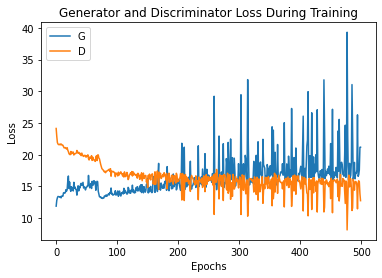

In [34]:
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.savefig("losses.png")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

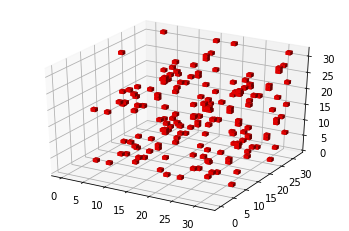

In [43]:
evalArray=torch.normal(torch.zeros(1, 200), 
                             torch.ones(1, 200) * .33).to(device)
evalArray=G_(evalArray)
T=0.99
evalArray[evalArray>T]=True
evalArray[evalArray<T]=False
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.voxels(evalArray.squeeze().detach().cpu().numpy(),facecolors='red')
fig.savefig('thresholded_T={0}.png'.format(T))
plt.show()